# Recommend System Project

In [ ]:
# Install NetworkX, Matplotlib, Pandas, Numpy using pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing and knowing data

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import cosine
from pandas.core.frame import DataFrame

In [ ]:
from google.colab import drive
drivePath = '/content/drive' #please do not change
drive.mount(drivePath)


Mounted at /content/drive


In [ ]:
figuresPath = '/content/drive/MyDrive/Colab Notebooks/data/recipe_dataset2.csv'

In [ ]:
df = pd.read_csv(figuresPath)

In [ ]:
# checkin the type and take a glance at the head
print(type(df))
df.head(5)

<class 'pandas.core.frame.DataFrame'>


,Date,UserID,RecipeID,Event
0,2022-01-10 11:23:59,1031,68,view_recipe
1,2022-01-10 11:25:09,1031,68,short_description
2,2022-01-10 11:27:29,1031,68,steps
3,2022-01-10 11:43:48,433,194,view_recipe
4,2022-01-10 11:45:44,433,194,long_description


# Create user-item matrix (weighting｜normalization)


## Binary Matrix

First build user-id and recipe-id into a two-dimensional matrix

In [ ]:
userID = df.UserID.unique()
recipeID = df.RecipeID.unique()
uiMatrix = pd.DataFrame(columns=recipeID, index=userID)
uiMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
uiMatrix.info

<bound method DataFrame.info of       68   194  470  349  353  427  284  293  456  233  ...  484  93   31   \
1031  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
433   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1428  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1740  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
67    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1976  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1315  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1672  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
194   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
509   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      247  294  184  18   179  

## Behavioural Implicit Ratings
In this section, we used the formula I learned in class to calculate the behavioral implicit rating.

Using the formula

$${IR}_(i,u) = \left(w_1*{\#event}_1\right)+\left(w_2*{\#event}_2\right)+\dots+\left(w_n*{\#event}_n\right)$$
 and
$${IRDecay}_{(i,u)} = \sum_{i=1}^n w_i*{\#event}_i*d\left({\#event}_i\right) = \left(w_1*{\#event}_1*d\left({\#event}_1\right)\right)+\left(w_2*{\#event}_2*d\left({\#event}_2\right)\right)+\dots+\left(w_n*{\#event}_n*d\left({\#event}_n\right)\right)$$

In [ ]:
eventTypes = df.Event.unique()
print(eventTypes)

['view_recipe' 'short_description' 'steps' 'long_description'
 'view_comments']


### Give a weight to each of them

At first we tried to empower user behavior with our own ideas, but after we visualized the user behavior data rows, we found that the order of user behavior is: view_recipe - steps - short_description - long_description - view_comments. So we give view_recipe a weight of 0, steps 10, short_description 30, long_description, view_comments 100.

In [ ]:
eventWeights = {
    'view_recipe': 0,
    'short_description': 30,
    'long_description': 70,
    'view_comments': 100,
    'steps': 10}

# Iterate the evidence
for index, row in df.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentRecipe = row['RecipeID']

    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']]

    # Find the value eventually stored for the current user-item combination
    currentValue = uiMatrix.at[currentUser, currentRecipe]
    if np.isnan(currentValue):
        currentValue = 0

    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + w #+ (1 * w)
    uiMatrix.at[currentUser, currentRecipe] = updatedValue

uiMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,110,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Using decay factor
Since the user's interest will change over time, the recipes read a few days ago may not be of interest now. When calculating the implicit rating, we consider the time series problem and add the decay factor. We set the threshold of the decay factor to 30 days, because after a month, changes in climate and temperature may affect people's dietary preferences and change people's interest in a certain dish.


In [ ]:
import datetime
from datetime import date, timedelta, datetime

def compute_decay(eventDate, decayDays):
    age = (date.today() - datetime.strptime(eventDate, '%Y-%m-%d %H:%M:%S').date()) // timedelta(days=decayDays)
    #print("Age of event:", age)
    decay = 1/age #simple decay
    #print("Decay factor:", decay)

    return decay


In [ ]:
#Create a user-item matrix
decay_uiMatrix = pd.DataFrame(columns=recipeID, index=userID)

# Iterate the evidence
for index, row in df.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentRecipe = row['RecipeID']

    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']]
    createdEvent = df.at[0,'Date']
    thresholdDays = 30 # Number of days
    decayFactor = compute_decay(createdEvent, thresholdDays)

    # Find the value eventually stored for the current user-item combination
    currentValue = decay_uiMatrix.at[currentUser, currentRecipe]
    if np.isnan(currentValue):
        currentValue = 0

    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + (w * decayFactor) # the weight is time-decayed
    decay_uiMatrix.at[currentUser, currentRecipe] = updatedValue

decay_uiMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,7.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.666667
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data preprocessing

To improve the convergence speed and accuracy of the model, we normalized and normalized the data. At the same time, in order to eliminate the data offset and reduce the collinearity between features, we decentralized the rating matrix.

#### Normalise the matrix

In [ ]:
uiMatrixNorm = decay_uiMatrix.apply(
    lambda x: ((x - np.nanmin(decay_uiMatrix.values))/(np.nanmax(decay_uiMatrix.values) - np.nanmin(decay_uiMatrix.values)))*10
    )

uiMatrixNorm

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,2.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,4.166667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fill NaN
In real life, the rating matrix should be a non-empty matrix, either 0 or other numbers. Since different filling methods will have different effects in different scenarios, we tried two methods to fill the matrix: filling with 0 and filling with the average value.

##### fill(0)

In [ ]:
uiMatrixNorm_fillna = uiMatrixNorm.fillna(0)
uiMatrixNorm_fillna

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,1.25,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
433,0.00,2.916667,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1428,0.00,0.000000,1.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1740,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
67,0.00,0.000000,0.00,0.0,4.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1315,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.25
1672,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
194,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


##### fillmean


In [ ]:
uiMatrixNorm_fillmean = uiMatrixNorm.apply(lambda row: row.fillna(row.mean()), axis=1)
uiMatrixNorm_fillmean

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,1.250000,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,...,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667
433,2.083333,2.916667,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,...,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333,2.083333
1428,2.708333,2.708333,1.250000,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,...,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333,2.708333
1740,1.805556,1.805556,1.805556,0.000000,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556,...,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556,1.805556
67,4.791667,4.791667,4.791667,4.791667,4.166667,4.791667,4.791667,4.791667,4.791667,4.791667,...,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667,4.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,...,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667
1315,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,...,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000
1672,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333
194,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333


#### Decentralized

In [ ]:
uiMatrixNorm_submean = uiMatrixNorm.sub(uiMatrixNorm.mean(axis=0), axis=1)
uiMatrixNorm_submean

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,-0.681818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,-1.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,-3.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,-4.097222,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,-0.092593,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check the sparsity of the matrix：

After calculating the user-item rating matrix, we calculated the sparsity of the matrix and found that the sparsity is 99.54%. The data is different from the example given by the teacher in class and is closer to the real data. We need to consider the data sparsity problem

In [ ]:
# Compute sparsity value of the matrix

# Number of possible ratings
matrixSize = uiMatrixNorm.shape[0]*uiMatrixNorm.shape[1]

# Number of na elements
matrixNA = uiMatrixNorm.isna().sum().sum()

# Sparsity value
uiMatrixSparsity = matrixNA / matrixSize
uiMatrixSparsity

0.9954145091154225

# User-based Collaborative Filtering


## Select user for recommend
Select user 122 and recommend recipes for user 122 later

In [ ]:
currentUser = 122 # Selected user
uiMatrixNorm = uiMatrixNorm.astype(float)

## Calculate similarity

### Pearson method:

Because the item-based matrix is too sparse, the calculated similarity cannot be used. After sorting the output results in descending order, we can see that except user (id: 122) itself, only user (id: 213) is exactly the same as her, and the others are all NaN values, which makes us unable to find similar users, so we decided to try other method.

In [ ]:
cuDf = uiMatrixNorm.loc[currentUser]

corrDf = uiMatrixNorm.corrwith(cuDf, axis=1, method='pearson')
corrDf.sort_values(ascending=False, inplace=True)
corrDf

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


122     1.0
213     1.0
1031    NaN
433     NaN
1428    NaN
       ... 
1976    NaN
1315    NaN
1672    NaN
194     NaN
509     NaN
Length: 1698, dtype: float64

### Cosine Method
Here we try to change cos to calculate the similarity. First, we defined a cos function, and then we used the normalized and decentralized rating matrices to calculate the similarity between users, but after manual proofreading, we found that the similarity calculated by using the decentralized rating matrix inaccurate, so we use the similarity matrix computed using the normalized rating matrix

#### Define function —— cosine_sim

In [ ]:
def cosine_sim(df1, df2):
    # check for na in dataframes
    df1na = df1.isna()
    df1clean = df1[~df1na]
    df2clean = df2[~df1na]

    df2na = df2clean.isna()
    df1clean = df1clean[~df2na]
    df2clean = df2clean[~df2na]


    # Compute cosine similarity
    distance = cosine(df1clean, df2clean)
    sim = 1 - distance

    return sim

#### Calculate similarity (Normalized Matrix)

In [ ]:
cuDf_norm = uiMatrixNorm.loc[currentUser] # The user's operation score for all recipes
cuDf_norm

cosine_list = []
user_list = []
for row in uiMatrixNorm.iterrows():
  y = row[1]
  item = row[0]
  cosine_xy = cosine_sim(cuDf_norm.fillna(0),y.fillna(0))
  cosine_list.append(cosine_xy)
  user_list.append(item)
data = {'user':user_list,
          'cosine':cosine_list}
cu_cos = DataFrame(data)

cu_cos.sort_values('cosine',ascending = False)

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,user,cosine
1179,748,1.0
795,170,1.0
1195,953,1.0
1088,1038,1.0
171,122,1.0
...,...,...
579,779,0.0
578,1546,0.0
577,723,0.0
576,565,0.0


#### Calculate similarity (Decentralization Matrix)

In [ ]:
cuDf_submean = uiMatrixNorm_submean.loc[currentUser] # The user's action score for all recipes
cuDf_submean

cosine_list = []
user_list = []
for row in uiMatrixNorm_submean.iterrows():
  y = row[1]
  item = row[0]
  cosine_xy = cosine_sim(cuDf_submean.fillna(0),y.fillna(0))
  cosine_list.append(cosine_xy)
  user_list.append(item)
data = {'user':user_list,
          'cosine':cosine_list}
CosDataFrame = DataFrame(data)

CosDataFrame.sort_values('cosine',ascending = False)

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,user,cosine
243,1194,1.000000
171,122,1.000000
1204,63,1.000000
472,81,1.000000
1672,972,1.000000
...,...,...
760,1192,-0.459936
1092,430,-0.537093
919,886,-0.595987
1489,760,-0.736145


In [ ]:
#remove current user's row for next steps
index = cu_cos[cu_cos.user==122].index.values
cu_cos.drop(index=index, inplace=True)

## Recommend

Using Cosine Method

In this part, we set user_threshold=0 to filter out users who are completely different from 122 users. Select the top 10 users with the highest similarity with 122 users. According to the ratings given by these 10 users to the recipes, predict scores for 122 recipes that have not been rated by users. Finally, the top 5 recipes with the highest scores are selected for recommendation.

Finally, we define a function to calculate the user coverage to evaluate the recommender system. At first, when we set the threshold to 0.5, we found that the user coverage rate was too low, and the system’s ability to recommend and discover the long tail was low, so we tried to raise and lower the threshold, and finally let the threshold be at a level with a higher user coverage.

In [ ]:
user_threshold2 = 0

In [ ]:
#Select users whose similarity with 122 is greater than 0 and sort them
selected_cos = pd.DataFrame(columns=['user','cosine'])
A = cu_cos['user'].tolist()

for a in A :
  cos = cu_cos['cosine'][cu_cos['user']==a]
  if cos.values > user_threshold:
    selected_cos.loc[len(selected_cos.index)] = [a,cos.values]


selected_cos.sort_values('cosine',ascending = False)

,user,cosine
73,748,[1.0]
84,394,[1.0]
31,1931,[1.0]
32,1894,[1.0]
58,170,[1.0]
...,...,...
56,1424,[0.01886365532160983]
69,1948,[0.017187093866874337]
9,893,[0.015575130657627168]
68,25,[0.015575130657627168]


In [ ]:
#Top 10 users with the highest similarity with 122
corrDf = cu_cos.sort_values('cosine',ascending = False).head(10)
corrDf

,user,cosine
1179,748,1.0
1567,191,1.0
795,170,1.0
1195,953,1.0
1088,1038,1.0
1539,49,1.0
470,1894,1.0
1465,394,1.0
331,1849,1.0
452,1931,1.0


In [ ]:
#Selected 122 recipes that have not been rated
toPredict = cuDf[cuDf.isna()]
toPredict

68    NaN
194   NaN
470   NaN
349   NaN
353   NaN
       ..
184   NaN
18    NaN
179   NaN
259   NaN
478   NaN
Name: 122, Length: 470, dtype: float64

In [ ]:
len(toPredict)

470

In [ ]:
ratings = uiMatrixNorm.loc[corrDf.index]
ratings

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x1 = ratings.index.tolist()
y1 = ratings.columns

recommend = pd.DataFrame(columns=['recipe_id','rating'])

for i in x1:
  for j in y1:
    value = uiMatrixNorm_fillna[j][i]
    #print(value)
    if value != 0 :
        recommend.loc[len(recommend.index)] = [j, value]
    #break

recommend.sort_values('rating',ascending = False)

,recipe_id,rating
0,141.0,8.333333
6,208.0,8.333333
15,379.0,8.333333
11,380.0,8.333333
8,152.0,8.333333
18,20.0,8.333333
3,98.0,8.333333
10,289.0,5.416667
16,98.0,5.416667
5,467.0,4.166667


In [ ]:
#Top-5
recommend.head(5)

,recipe_id,rating
0,141.0,8.333333
1,270.0,1.250000
2,164.0,4.166667
3,98.0,8.333333
4,496.0,4.166667


### user coverage

In [ ]:
def user_coverage(selected_cos,cu_cos): #selected_cos：设置阈值后取的cosine dataframe，cu_cos：归一后的dataframe

   no_users_in_rec = len(selected_cos.user)
   no_users = len(cu_cos)+1
   user_coverage = no_users_in_rec/no_users

   return user_coverage

In [ ]:
user_coverage(selected_cos,cu_cos)

0.05535924617196702

# Item-based Collaborative Filtering

## Calculate similarity


### Similarity Precomputation

In order to improve the recommendation efficiency, we calculate the similarity in advance and provide more information for the algorithm through pre-computation, thereby improving the accuracy and coverage of the recommendation

In [ ]:
#Convert to boolean matrix
uiRecipeBool = uiMatrixNorm.mask(uiMatrixNorm>0,1)
uiRecipeMatrixBool = uiRecipeBool.fillna(0)
uiRecipeMatrixBool.head(3)

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Multiply item * item by using 'dot' function
uiRecipeMatrixOverlapping = uiRecipeMatrixBool.T.dot(uiRecipeMatrixBool)
uiRecipeMatrixOverlapping.shape
uiRecipeMatrixOverlapping.head()

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
68,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate each item's pair similarity, then save the result in the similarity matrix

In [ ]:
#create item-item similarity
iiSimMatrix = pd.DataFrame().reindex_like(uiRecipeMatrixOverlapping)
iiSimMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Extract the movies' list
recipeToPrecompute = iiSimMatrix.columns

#Extract the item's pair ratings
for item1 in recipeToPrecompute:
    item1Ratings = uiMatrixNorm[item1]
    for item2 in recipeToPrecompute:
        item2Ratings = uiMatrixNorm[item2]

        # If there is overlapping of rating then precompute the cosine similarity
        # Here you can modify the threshold of minimum overlapping ratings (now set to 0)
        threshold = 0
        # You can also use the average number of ratings to reduce the number of computations
        #threshold = uiMovieMatrixOverlapping.sum(axis=0).mean()
        if uiRecipeMatrixOverlapping.at[item1,item2] > threshold:
            iiSimMatrix.at[item1, item2] = cosine_sim(item1Ratings, item2Ratings)

In [ ]:
iiSimMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
68,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


## Recommend by cosine method

In this part, we start to make item-based recommendations. We first select all the recipes rated by 122 users, and set two parameters for data filtering: the first parameter is to filter out the scores of recipes rated by 122 users For recipes greater than 2, the second parameter is to find recipes whose similarity with these recipes is greater than 0.5 from the similarity matrix for recommendation. However, by calculating the coverage rate of the directory, we found that the coverage rate is only 27%, so we choose to add top-k on this basis to recommend suitable recipes to users.

In [ ]:
#Select the line where 122 is located
cuDf = uiMatrixNorm.loc[currentUser]
cuDf

68    NaN
194   NaN
470   NaN
349   NaN
353   NaN
       ..
184   NaN
18    NaN
179   NaN
259   NaN
478   NaN
Name: 122, Length: 477, dtype: float64

In [ ]:
#Select 122 rated recipes
cur_recipe = cuDf[cuDf.notnull()]
cur_recipe

186    5.416667
322    4.166667
342    4.166667
325    1.250000
273    1.250000
245    4.166667
280    5.416667
Name: 122, dtype: float64

In [ ]:
columns = iiSimMatrix.columns

In [ ]:
filna_iiSimMatrix = iiSimMatrix.fillna(0)
filna_iiSimMatrix

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
68,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
item_threshold = 0.5

In [ ]:
select_recipe = []
recipe_ID = []
similarity = []

for i in cur_recipe.index:
  if cur_recipe[i] > 2:
    select_recipe.append(i)

recipe_ID = []
similarity = []

for j in select_recipe:
  for i in columns:
     value = filna_iiSimMatrix[i][j]
     if value > item_threshold:
        recipe_ID.append(i)
        similarity.append(filna_iiSimMatrix[i][j])
c={"recipe_ID" : recipe_ID,
   "similarity" : similarity}
dF1 = pd.DataFrame(c)

dF1.sort_values('similarity',ascending = False)

,recipe_ID,similarity
0,298,1.000000
81,273,1.000000
94,342,1.000000
93,76,1.000000
92,322,1.000000
...,...,...
12,399,0.993653
10,325,0.991600
120,481,0.974391
42,342,0.811756


#### catalogue coverage

In [ ]:
def catalogue_coverage(dF1,iiSimMatrix): #selected_cos：设置阈值后取的cosine dataframe，cu_cos：归一后的dataframe

   no_items_in_rec = len(dF1.recipe_ID)
   no_items = len(iiSimMatrix.index)
   catalogue_coverage = no_items_in_rec/no_items

   return catalogue_coverage

In [ ]:
catalogue_coverage(dF1,iiSimMatrix)

0.27044025157232704

In [ ]:
dF1.sort_values('similarity',ascending = False).head(5)

,recipe_ID,similarity
0,298,1.0
81,273,1.0
94,342,1.0
93,76,1.0
92,322,1.0


In [ ]:
x = uiMatrixNorm.index.tolist()
y = uiMatrixNorm.columns

New = pd.DataFrame(columns=['u_id','i_id','rating'])

for i in x:
  for j in y:
    value = uiMatrixNorm_fillna[j][i]
    #print(value)
    if value != 0 :
        New.loc[len(New.index)] = [i, j, value]
    #break

print(New)

        u_id   i_id    rating
0     1031.0   68.0  1.250000
1     1031.0  142.0  8.333333
2     1031.0  339.0  8.333333
3     1031.0  417.0  1.250000
4      433.0  194.0  2.916667
...      ...    ...       ...
3650  1976.0  191.0  4.166667
3651  1315.0  478.0  1.250000
3652  1672.0  308.0  8.333333
3653   194.0  129.0  8.333333
3654   509.0  447.0  1.250000

[3655 rows x 3 columns]


#### Recommend the top-k items to the user

In [ ]:
currentUser = 122
currentItem = 146
numItems = 5 # top-5

In [ ]:
def itemCF_precomputed(similarityMatrix, currentItem, numItems):
    #Select current item from the similarity matrix, remove not rated items, sort the values and select the top-k items
    recommendationList = similarityMatrix[currentItem].dropna().sort_values(ascending=False).head(numItems)

    return recommendationList.index.to_list()

In [ ]:
cuRatedMovies = uiMatrixNorm.loc[122].dropna().sort_values(ascending=False)
cuRatedMovies

186    5.416667
280    5.416667
322    4.166667
342    4.166667
245    4.166667
325    1.250000
273    1.250000
Name: 122, dtype: float64

In [ ]:
# choose one movie to find the similar movies to reccommend
itemCF_precomputed(iiSimMatrix, currentItem, numItems)

[267, 162, 249, 71, 480]

## Recommend by predicting rating
In addition to using cos similarity for item-based recommendation, we can also try to predict scores for items to make recommendations. Here we have tried a variety of methods for item score prediction


### Use SVD to predict the rating of user 122 on menu 146

In [ ]:
# Install NetworkX, Matplotlib, Pandas, Numpy using pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from numpy import linalg
import pandas as pd
import numpy as np

M = uiMatrixNorm_fillmean
U, Sigma, Vt = linalg.svd(M) # M = uiMatrixNorm_fillmean

In [ ]:
def prettify_matrix(matrix, decimals):
    print(np.array_str(matrix, precision=decimals, suppress_small=True))
    print('==========')

In [ ]:
def rank_k(U, Sigma, Vt, k):
    U_reduced= np.mat(U[:,:k])
    Vt_reduced = np.mat(Vt[:k,:])
    Sigma_reduced = np.eye(k)*Sigma[:k]

    return U_reduced, Sigma_reduced, Vt_reduced

In [ ]:
U_reduced, Sigma_reduced, Vt_reduced = rank_k(U, Sigma, Vt, 2)
M_hat = U_reduced * Sigma_reduced * Vt_reduced
prettify_matrix(M_hat, 3)

[[4.784 4.794 4.794 ... 4.792 4.792 4.792]
 [2.08  2.085 2.084 ... 2.083 2.083 2.083]
 [2.704 2.71  2.709 ... 2.708 2.708 2.708]
 ...
 [8.321 8.338 8.336 ... 8.333 8.333 8.333]
 [8.321 8.338 8.336 ... 8.333 8.333 8.333]
 [1.248 1.251 1.25  ... 1.25  1.25  1.25 ]]


In [ ]:
dfM_hat = pd.DataFrame(M_hat, columns=M.columns, index=M.index).round(3)
dfM_hat[146][122]

3.69

#### Try to predict the rating


In [ ]:
print('existing rating:', M[325][122].round(3))
print('predicted rating:', dfM_hat[325][122])

existing rating: 1.25
predicted rating: 3.694


In [ ]:
print('existing rating:', M[68][1031].round(3))
print('predicted rating:', dfM_hat[68][1031])

existing rating: 1.25
predicted rating: 4.784


In [ ]:
uiMatrixNorm[325][122]

1.25

### Use Funk SVD to predict the rating of user 122 on menu 146

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=1be27a5625a66b2e8c193ff8286681eb1c9d1d11825ee68e9b422a394ee7654d
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/gbolmier/funk-svd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-3mlhcbdx
  Running command git clone --filter=blob:none --quiet https://github.com/gbolmier/funk-svd /tmp/pip-req-build-3mlhcbdx
  Resolved https://github.com/gbolmier/funk-svd to commit fecc38ea1c2859ef6a6d9af0b7f953e1b693764e
  Preparing metadata (setup.py) ... done
  Created wheel for funk-svd: filename=funk_svd-0.0.1.dev1-py3-none-any.whl size=9057 sha256=39485d994b461bc0fa018fbdc8c66af3f8b41b73a97347e3a25a610d9b675d7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zcu3yjli/wheels/c1/5f/58/0d631ca5543c40b1e044d2a48dd1a8fbb6a7c189be1141b925
Successfully built funk-svd


In [ ]:
import pandas as pd
import numpy as np

from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD

from sklearn.metrics import mean_absolute_error

In [ ]:
x = uiMatrixNorm.index.tolist()
y = uiMatrixNorm.columns

New = pd.DataFrame(columns=['u_id','i_id','rating'])

for i in x:
  for j in y:
    value = uiMatrixNorm_fillna[j][i]
    #print(value)
    if value != 0 :
        New.loc[len(New.index)] = [i, j, value]
    #break

print(New)

        u_id   i_id    rating
0     1031.0   68.0  1.250000
1     1031.0  142.0  8.333333
2     1031.0  339.0  8.333333
3     1031.0  417.0  1.250000
4      433.0  194.0  2.916667
...      ...    ...       ...
3650  1976.0  191.0  4.166667
3651  1315.0  478.0  1.250000
3652  1672.0  308.0  8.333333
3653   194.0  129.0  8.333333
3654   509.0  447.0  1.250000

[3655 rows x 3 columns]


In [ ]:
New

,u_id,i_id,rating
0,1031.0,68.0,1.250000
1,1031.0,142.0,8.333333
2,1031.0,339.0,8.333333
3,1031.0,417.0,1.250000
4,433.0,194.0,2.916667
...,...,...,...
3650,1976.0,191.0,4.166667
3651,1315.0,478.0,1.250000
3652,1672.0,308.0,8.333333
3653,194.0,129.0,8.333333


In [ ]:
train = New.sample(frac=0.8, random_state=57) # 80% of dataset
val = New.drop(train.index.tolist()).sample(frac=0.5, random_state=42) # 50% of training set
test = New.drop(train.index.tolist()).drop(val.index.tolist()) # remaining 20% of dataset

# Setup the Funk SVD object
svd = SVD(lr=0.001, reg=0.005, n_epochs=100,
          early_stopping=True, shuffle=False,
          n_factors=15, min_rating=0, max_rating=10)



In [ ]:
svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 5.88 - val_rmse: 2.42 - val_mae: 1.93 - took 1.0 sec
Epoch 2/100  | val_loss: 5.88 - val_rmse: 2.43 - val_mae: 1.93 - took 0.0 sec

Training took 2 sec


In [ ]:
svd.predict_pair(122,146)

3.967818596651584

In [ ]:
 svd.predict_pair(1031,68)

3.941626865546212

#### Try to predict

In [ ]:
print('existing rating:', uiMatrixNorm[68][1031])
print('predicted rating:', svd.predict_pair(1031,68))

existing rating: 1.25
predicted rating: 3.941626865546212


### Failed prediction

In this step, we first find 19 users who have operated all recipes No. 146, and try to find out other recipes that these 19 users have operated at the same time, and only find recipe No. 146. It is impossible to predict the rating of recipe 146 by 122 users from the average rating of other recipes (19 users have operated at the same time).

In [ ]:
currentUser = 122
currentItem = 146

uiMatrixSelection = uiMatrixNorm.dropna(subset = [currentItem]) # 所有操作过146号食谱的用户
uiMatrixSelection # 19个用户操作过146号菜单

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
uiMatrixSelection = uiMatrixSelection.dropna(axis = 1) # 把这些用户共同操作过的电影都保留下来
uiMatrixSelection

,146
1943,5.416667
1845,1.250000
1129,1.250000
661,5.416667
467,1.250000
1928,5.416667
491,1.250000
873,1.250000
272,4.166667
261,1.250000


#### Pearson method:
Because the item-based matrix is too sparse, the calculated similarity cannot be used. After sorting the output results in descending order, we can see that, except recipe (id: 146) itself, only recipe (id: 378) has a similar value and is -1, and the others are all NaN values, which makes us unable to find similar users, so we Decided to try something else.

In [ ]:
currentItem = 146
ciDf = uiMatrixNorm[currentItem]

corrDf = uiMatrixNorm.corrwith(ciDf, axis=0, method='pearson')
corrDf.sort_values(ascending=False, inplace=True)
corrDf

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


146    1.0
378   -1.0
68     NaN
194    NaN
470    NaN
      ... 
184    NaN
18     NaN
179    NaN
259    NaN
478    NaN
Length: 477, dtype: float64

### Recommend

After comparing the results predicted by the two models of SVD and Funk SVD, we found that the results predicted by the Funk SVD model are closer to the real value, because our data is relatively sparse, and the SVD solution process requires a complete data matrix, while Funk- SVD only needs to have known score values for training, and it is more robust to the processing of missing data. So in the end we choose the result of Funk SVD prediction for recommendation

In [ ]:
recipe_id = df['RecipeID'].unique()
recipe_id

array([ 68, 194, 470, 349, 353, 427, 284, 293, 456, 233, 344,  43, 250,
        54, 360, 496,  46, 421, 298, 398, 467, 354, 438,  94, 240,  47,
       420, 195, 253, 335, 267, 244, 165, 213,  95, 489,  44, 458, 152,
        13, 295,  92, 436, 198, 260, 146, 263, 323, 441, 109, 128, 410,
       232, 197, 309,  49, 318,   5, 205, 180,  39, 462, 320, 142, 300,
       454, 242,  21, 186, 429, 448, 266, 336, 297, 158, 171, 330,  24,
       193, 494, 439, 356,  37, 169,  80,  16, 290, 338, 191,  45, 377,
       305, 322,  76, 384, 214,  87, 113, 328, 241, 306, 145,  74, 355,
        53, 166,  48, 225, 231, 392, 129, 287, 227, 307, 106, 329, 412,
       137, 419, 444,  65, 342, 312, 389, 208, 292, 243, 390, 112, 188,
       200, 161, 308, 269, 217, 204, 422, 472,   1, 255, 223, 222, 327,
       325, 130, 331, 334,  57, 108, 457, 219, 430, 486,  40, 256, 262,
       321, 258, 303, 144, 103, 386, 119,  72, 388,  82, 348, 343,  90,
       418,   9, 451,  55, 383, 428, 380, 283, 479, 399, 218,  2

In [ ]:
len(recipe_id)

477

In [ ]:
list1 = []
recipe = []
for i in recipe_id:
  pre_rating = svd.predict_pair(122,i)
  list1.append(pre_rating)
  recipe.append(i)
data = {"recipe_ID" : recipe,
   "rating" : list1}
rating_DF = pd.DataFrame(data)

In [ ]:
rating_DF

,recipe_ID,rating
0,68,3.946915
1,194,3.969216
2,470,3.964739
3,349,3.992631
4,353,3.926821
...,...,...
472,184,4.013508
473,18,3.910710
474,179,3.918045
475,259,3.957597


In [ ]:
rating_DF.sort_values('rating',ascending = False).head(5)

,recipe_ID,rating
185,379,4.089112
49,109,4.076383
371,265,4.074131
454,404,4.070001
211,156,4.067563


# Data Visualization

## Bar Chart of UserID & RecipeID

***Visual Analysis***

1. The first figure is the distribution bar chart of Userids. It can be found that the distribution of user ids is relatively average. As can be seen from the histogram, there is little difference in the number of visits to the website by different users. Applied to real life, good user activity can ensure the steady growth of the user group of the website.

2. The second chart is the recipeID distribution bar chart. From this chart, we can see that some Recipeid recipes receive a high number of visits, while others receive a relatively low number of visits. Applied to the real world, we can further analyze these popular recipes, provide users with more similar content, increase user satisfaction and loyalty, and improve these less visited recipes.

Through these two diagrams, we can further combine the event types for analysis, so as to understand the behavior of users on the website, which can be applied to real life for effective operation and formulation of promotion strategies.

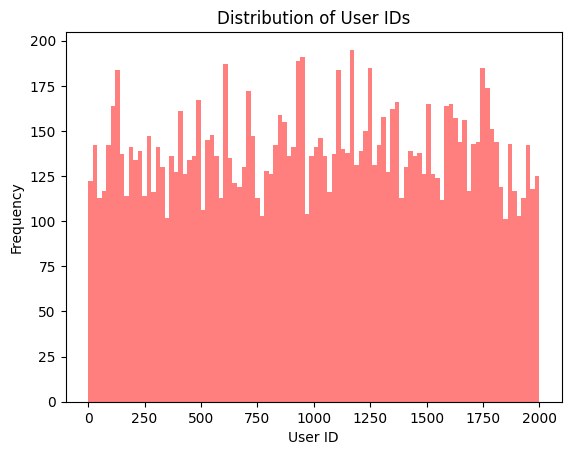

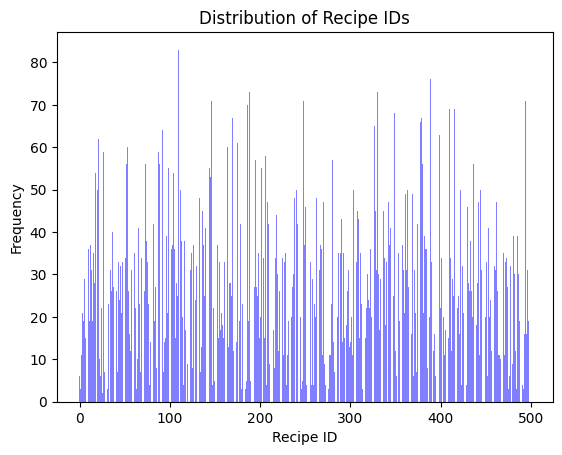

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df1 = pd.read_csv(figuresPath)

#bar chart of UserID
plt.hist(df1['UserID'], bins=100, alpha=0.5, color='r')
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.title('Distribution of User IDs')
plt.show()

#bar chart of recipeID
recipe_count = df1['RecipeID'].value_counts().reset_index()
recipe_count.columns = ['RecipeID', 'Count']
recipe_count = recipe_count.sort_values(by='RecipeID')
plt.bar(recipe_count['RecipeID'], recipe_count['Count'], width=0.8, alpha=0.5, color='b')
plt.xlabel('Recipe ID')
plt.ylabel('Frequency')
plt.title('Distribution of Recipe IDs')
plt.show()

## Scatter Plot of Event Count by Hour

***Visual Analysis***

In the scatter plot, we visualize how often different event types occur at different times of the day. Among them, each scatter represents a data point, and scatter points of different colors represent different event types.
We extracted the ‘Date’ attribute of dataset by “Hour", and set the horizontal coordinate as 24 scales, which corresponded to 24 hours in a day.

By observing the scatter distribution of different event types, we could understand the high occurrence time of each event type. For example, the peaks of long description appear at 7, 12, 18 and 21 respectively, indicating that the most users browse and concentrate on eating in these periods, which also correspond to several eating time points.

On the other hand, we can see that these three color events always occur in conjunction, with purple and green events at the top, followed by orange, and blue and red events at the bottom requiring deeper browsing. Therefore, we set the weight of each event according to this data as the basis of its importance.


In [ ]:
figuresPath1 ='/content/drive/MyDrive/Colab Notebooks/data/NEWrecipe_dataset2.csv'

<ipython-input-114-e97a31d6fcfc>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data['Hour'], data['Count'], alpha=0.5, cmap='viridis', label=event)


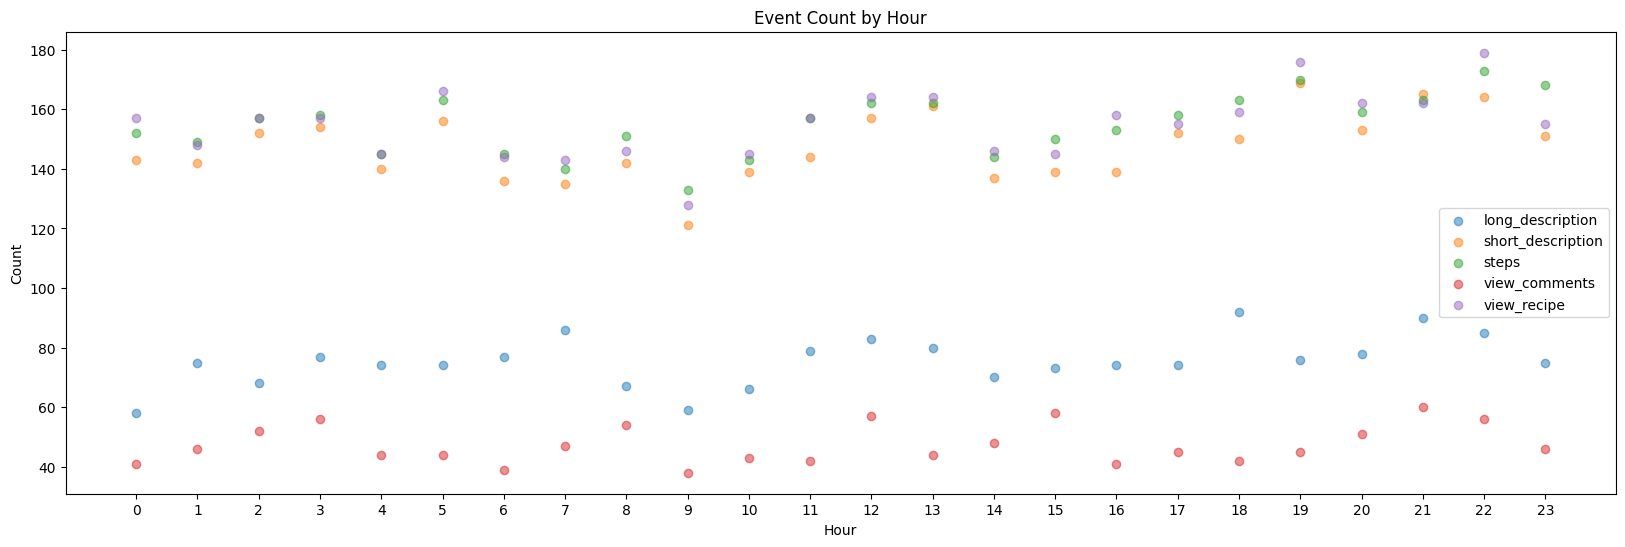

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df2 = pd.read_csv(figuresPath1)

#Number of events of different event types occurring per hour
freq = df2.groupby(['Hour', 'Event']).size().reset_index(name='Count')

#Scatter plot
fig, ax = plt.subplots(figsize=(20, 6))
for i, event in enumerate(freq['Event'].unique()):
    data = freq[freq['Event'] == event]
    ax.scatter(data['Hour'], data['Count'], alpha=0.5, cmap='viridis', label=event)

ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

#Mark the X-axis by 24 hours
ax.set_xticks(range(0, 24, 1))

ax.set_title('Event Count by Hour')
plt.show()

## Bar Chart of Event Count by Type

***Visual Analysis***

We can see that the view_recipe and short_description events get the most hits, followed by the step event. long_description and view_comments get less hits. The main purpose of using recipe websites is to read recipes and learn how to cook. And view the introduction is also the first step to understand the recipe, so the page view is larger. At the same time, there are plenty of people who want to learn more about how to cook. The lowest number of people checking reviews indicates a low level of interest.

In [ ]:
# Create a new dataframe with row as the index and column as the five types of event
eventDF = pd.DataFrame(index=range(len(eventTypes)), columns=['view_recipe', 'short_description', 'long_description', 'view_comments', 'steps'])

# Iterate the evidence and count the number of each event
for eventType in eventTypes:
    eventCount = len(df[df['Event'] == eventType])
    eventDF.at[eventTypes.tolist().index(eventType), eventType] = eventCount

eventDF

,view_recipe,short_description,long_description,view_comments,steps
0,3718,NaN,NaN,NaN,NaN
1,NaN,3541,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,3718
3,NaN,NaN,1810,NaN,NaN
4,NaN,NaN,NaN,1139,NaN


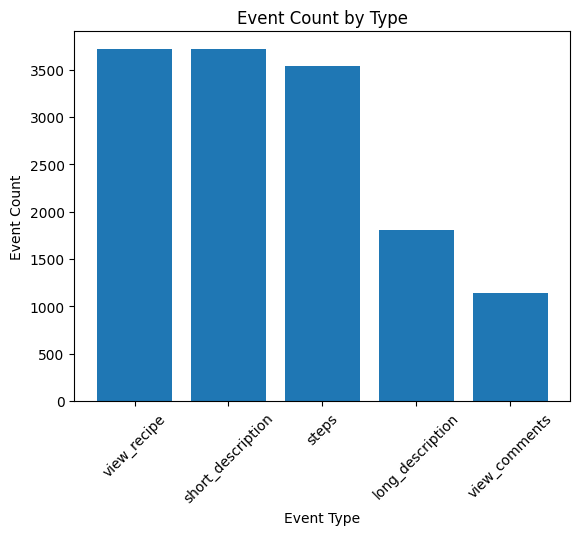

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.bar(eventTypes, eventDF.sum(axis=1).sort_values(ascending=False))
#print(eventDF.sum(axis=1).sort_values(ascending=False))

# Set the x-label, y-label and title of the chart
plt.xlabel('Event Type')
plt.ylabel('Event Count')
plt.title('Event Count by Type')
plt.xticks(rotation=45)

# Show the chart
plt.show()

## Bar Chart of Top ten weights of recipe

***Visual Analysis***

This figure shows The top ten recipeIDs in statistical weights. We count the events after giving weights to each recipeID, and then use top-k method to get the top ten Recipeids. From this chart, we can find that 109,494,379,389,295,186,232,21,325 and 330 are the top 10 recipes, which can be used for non-personalized recommendations.

In [ ]:
#total sum of weights
uiMatrixNorm.loc['weight_sum']=uiMatrixNorm.apply(lambda x:x.sum())
uiMatrixNorm

,68,194,470,349,353,427,284,293,456,233,...,484,93,31,247,294,184,18,179,259,478
1031,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,2.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,4.166667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
topTenWeight = uiMatrixNorm.apply(pd.to_numeric).loc['weight_sum'].nlargest(10)
topTenWeight
#type(topTenWeight)

109    97.500000
494    92.083333
379    87.083333
389    85.000000
295    85.000000
232    80.833333
21     79.583333
330    79.166667
325    78.333333
110    76.666667
Name: weight_sum, dtype: float64

In [ ]:
df_top=topTenWeight.to_frame()
df_top

,weight_sum
109,97.500000
494,92.083333
379,87.083333
389,85.000000
295,85.000000
232,80.833333
21,79.583333
330,79.166667
325,78.333333
110,76.666667


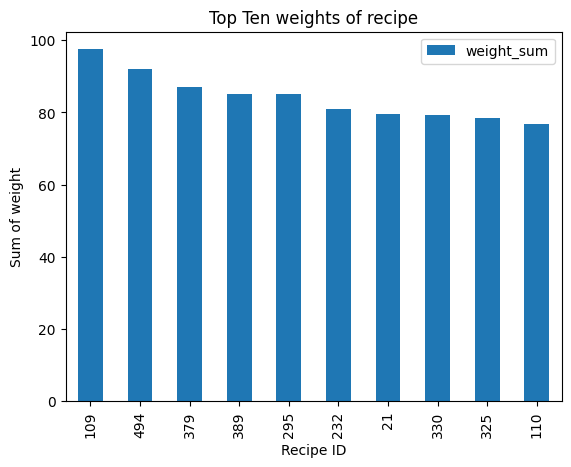

In [ ]:
df_top.plot(kind='bar')

plt.xlabel('Recipe ID')
plt.ylabel('Sum of weight')
plt.title('Top Ten weights of recipe')

plt.show()